In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [40]:
df = pd.read_csv("intern_car_regg.csv")
df.head()

,Avtosalon,Qiymet,Valyuta,Şəhər,Marka,Model,Buraxılış ili,Ban növü,Rəng,Mühərrik,...,Yeni,Vəziyyəti,Yeniləndi,Baxışların sayı,Extra,Etrafli,Sahiblər,Hansı bazar üçün yığılıb,Yerlərin sayı,Qəzalı
0,0,13500,AZN,Bakı,Opel,Vectra,2000,Hetçbek,Göy,1.6 L/101 a.g./Benzin,...,Xeyr,"Vuruğu yoxdur, rənglənib",28.05.2023,267,"Yüngül lehimli disklər, ABS, Kondisioner, Dəri...",Salam Barter mümkündür. 1.6 sadə mator mexanik...,2,Avropa,5,NaN
1,1,23500,USD,Bakı,Toyota,Corolla,2023,Sedan,Mavi,1.8 L/178 a.g./Hibrid,...,Bəli,"Vuruğu yoxdur, rənglənməyib",28.05.2023,12410,"Yüngül lehimli disklər, ABS, Yağış sensoru, Mə...",TOYOTA CAROLLA 2023 ALIŞ. 2 İL 80.000 KM ZƏMAN...,1,Rəsmi diler,5,NaN
2,0,33200,AZN,Bakı,Hyundai,Santa Fe,2013,Offroader / SUV,Qara,2.0 L/184 a.g./Dizel,...,Xeyr,"Vuruğu yoxdur, rənglənməyib",28.05.2023,148,"Yüngül lehimli disklər, ABS, Lyuk, Yağış senso...",Yeni gelib bakida surlmuyb qiymet mawin yanind...,1,Avropa,7,NaN
3,0,17000,AZN,Bakı,Ford,Fusion,2015,Sedan,Göy,1.5 L/181 a.g./Benzin,...,Xeyr,"Vuruğu yoxdur, rənglənməyib",25.05.2023,3358,"Yüngül lehimli disklər, ABS, Yağış sensoru, Mə...",Maşın xanım tərəfindən idarə olunub,NaN,NaN,NaN,NaN
4,0,36000,USD,Bakı,Toyota,RAV4,2022,Offroader / SUV,Qara,2.0 L/173 a.g./Benzin,...,Bəli,"Vuruğu yoxdur, rənglənməyib",28.05.2023,16183,"Yüngül lehimli disklər, ABS, Yağış sensoru, Mə...",Rəsmi dilerdən 10 il və ya 160.000 km zəmanəti...,1,NaN,5,NaN


In [41]:
df.shape

(10000, 23)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Avtosalon                 10000 non-null  int64 
 1   Qiymet                    10000 non-null  int64 
 2   Valyuta                   10000 non-null  object
 3   Şəhər                     10000 non-null  object
 4   Marka                     10000 non-null  object
 5   Model                     10000 non-null  object
 6   Buraxılış ili             10000 non-null  int64 
 7   Ban növü                  10000 non-null  object
 8   Rəng                      10000 non-null  object
 9   Mühərrik                  10000 non-null  object
 10  Yürüş                     10000 non-null  object
 11  Sürətlər qutusu           10000 non-null  object
 12  Ötürücü                   10000 non-null  object
 13  Yeni                      10000 non-null  object
 14  Vəziyyəti              

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avtosalon,10000.0,0.2537,0.435150,0.0,0.00,0.0,1.00,1.0
Qiymet,10000.0,27318.5214,28995.789851,1100.0,12700.00,21000.0,32500.00,850000.0
Buraxılış ili,10000.0,2010.0679,8.386246,1938.0,2006.00,2011.0,2015.00,2023.0
Baxışların sayı,10000.0,4328.8188,13383.511716,41.0,408.75,1164.5,3500.25,334547.0


# Data PreProcessing

## Data Columns Overview

In [44]:
df['Sahiblər'].unique()

array(['2', '1', nan, '0', '3', '4 və daha çox'], dtype=object)

In [45]:
df.drop(columns = 'Sahiblər', inplace = True)

In [46]:
df['Hansı bazar üçün yığılıb'].unique()

array(['Avropa', 'Rəsmi diler', nan, 'Amerika', 'Koreya', 'Rusiya',
       'Digər', 'Dubay', 'Yaponiya'], dtype=object)

In [47]:
df['Yürüş'].unique()

array(['370 000 km', '0 km', '168 636 km', ..., '61 130 km', '299 785 km',
       '181 500 km'], dtype=object)

In [48]:
def clean_mileage(value):
    cleaned_value = value.replace(' km', '').replace(' ', '')
    return int(cleaned_value)

df['Yürüş'] = df['Yürüş'].apply(clean_mileage)

In [49]:
df['Yürüş'] = df['Yürüş'].astype(np.int64)

In [50]:
df['Qiymet'] = df['Qiymet'].astype(float)

In [51]:
# valyutani azn e cevirir ve buna esasen qiymetleri tenzimleyir
df.loc[df['Valyuta']=='USD',['Qiymet']]=df.loc[df['Valyuta']=='USD',['Qiymet']].apply(lambda x:x*1.7)
df.loc[df['Valyuta']=='EUR',['Qiymet']]=df.loc[df['Valyuta']=='EUR',['Qiymet']].apply(lambda x:x*1.84)

In [52]:
df.drop('Valyuta',axis=1,inplace=True)

In [53]:
 df['Yerlərin sayı'].unique()

array(['5', '7', nan, '4', '3', '2', '8+', '1', '6'], dtype=object)

In [54]:
df['Yerlərin sayı'] = df['Yerlərin sayı'].replace('8+', '8')
df['Yerlərin sayı'] = pd.to_numeric(df['Yerlərin sayı'], errors='coerce')

In [55]:
df['Etrafli'].unique()

array(['Salam Barter mümkündür. 1.6 sadə mator mexanika Mator karobka və peredok ideal vəziyyətdədir UPC bufer BMW faralar SHMITZER qrusitel. Hamısı zövqlə yığılıb. Çox gözəl görünüşə malikdir. Ən əsası rasxodsuz maşındır. Şəhər içi 8lt trasda 6.5lt benzin sərfiyyatı var Bugünə olan problemi kondisioneri işləmir və maşına bütöv palirovka lazımdır. Hamısı bur yerdə 500azn xərci olar maksimum. Hər şeyi nəzərə alınıb bu qiymətə qoyulub Nömrə nişanı daxil satılır!.!.',
       'TOYOTA CAROLLA 2023 ALIŞ. 2 İL 80.000 KM ZƏMANƏT.. BARTER MÜNKÜNDÜR. KREDİT MÜNKÜNDÜR. Əlavə məlumat üçün zəng edin.',
       'Yeni gelib bakida surlmuyb qiymet mawin yaninda daliwlacaq  polnu ful en full versiya star stop sdenik qizdirici soyuducu polu luk wuwe tavan tecili satilir may ayin 26 tis gelib',
       ...,
       'Salam . Masinin ancag yungul kasmetikaya ehdiyaci var basqa hecbir problemi yoxdur zedesiz masindir elave xercleri yaransa men qarsilayacam proberq arginaldir dozumlu masindir android monitoru v

In [56]:
df.drop(['Etrafli','Yeniləndi','Şəhər','Rəng'], axis = 1, inplace = True)

## Filling of NA

In [57]:
df.isnull().sum()

Avtosalon                      0
Qiymet                         0
Marka                          0
Model                          0
Buraxılış ili                  0
Ban növü                       0
Mühərrik                       0
Yürüş                          0
Sürətlər qutusu                0
Ötürücü                        0
Yeni                           0
Vəziyyəti                     28
Baxışların sayı                0
Extra                        764
Hansı bazar üçün yığılıb    3298
Yerlərin sayı               3168
Qəzalı                      9968
dtype: int64

In [58]:
df.drop(columns = 'Qəzalı', inplace = True)

In [59]:
mode_value = df.Extra.mode().values[0]
print(f"Extra sutunun en cox tekrarlanan deyeri: {mode_value}")

Extra sutunun en cox tekrarlanan deyeri: Yüngül lehimli disklər, ABS, Lyuk, Yağış sensoru, Mərkəzi qapanma, Park radarı, Kondisioner, Oturacaqların isidilməsi, Dəri salon, Ksenon lampalar, Arxa görüntü kamerası, Yan pərdələr, Oturacaqların ventilyasiyası


In [60]:
mode_imputer = SimpleImputer(strategy = 'most_frequent')
df['Extra'] = mode_imputer.fit_transform(df[['Extra']])[:, 0]

assert df.Extra.isna().sum() == 0

In [61]:
mode_value = df.Vəziyyəti.mode().values[0]
print(f"Vəziyyəti sutunun en cox tekrarlanan deyeri: {mode_value}")

Vəziyyəti sutunun en cox tekrarlanan deyeri: Vuruğu yoxdur, rənglənməyib


In [62]:
mode_imputer = SimpleImputer(strategy = 'most_frequent')
df['Vəziyyəti'] = mode_imputer.fit_transform(df[['Vəziyyəti']])[:, 0]

assert df.Vəziyyəti.isna().sum() == 0

In [63]:
mode_value = df['Hansı bazar üçün yığılıb'].mode().values[0]
print(f"Hansı bazar üçün yığılıb sutunun en cox tekrarlanan deyeri: {mode_value}")

Hansı bazar üçün yığılıb sutunun en cox tekrarlanan deyeri: Avropa


In [64]:
mode_imputer = SimpleImputer(strategy = 'most_frequent')
df['Hansı bazar üçün yığılıb'] = mode_imputer.fit_transform(df[['Hansı bazar üçün yığılıb']])[:, 0]

assert df['Hansı bazar üçün yığılıb'].isna().sum() == 0

In [65]:
mode_value = df['Yerlərin sayı'].mode().values[0]
print(f"Yerlərin sayı sutunun en cox tekrarlanan deyeri: {mode_value}")

Yerlərin sayı sutunun en cox tekrarlanan deyeri: 5.0


In [66]:
mode_imputer = SimpleImputer(strategy = 'most_frequent')
df['Yerlərin sayı'] = mode_imputer.fit_transform(df[['Yerlərin sayı']])[:, 0]

assert df['Yerlərin sayı'].isna().sum() == 0

In [68]:
df['Yerlərin sayı'] = df['Yerlərin sayı'].astype('int')

In [69]:
df.isnull().sum().sum()

0

In [70]:
df.duplicated().sum()

0

## Feature engineering

In [71]:
# extra colundaki en cox tekrarlanan deyeri secir ve  onu vergulnen ayirir 
extra_col_names= df['Extra'].value_counts().index[0].split(", ")

# yeni yaranan collarda eger split elediklerimiz varsa 1 yazar yoxdusa 0
for col in extra_col_names:
    df[col] = df['Extra'].apply(lambda x: 1 if col in str(x) else 0)

In [72]:
df.drop('Extra',axis=1,inplace=True)

In [73]:
df['Vəziyyəti'].value_counts()

Vəziyyəti
Vuruğu yoxdur, rənglənməyib    9185
Vuruğu yoxdur, rənglənib        696
Vuruğu var, rənglənib            73
Vuruğu var, rənglənməyib         46
Name: count, dtype: int64

In [74]:
df['Vəziyyəti_1'] = df['Vəziyyəti'].apply(lambda x: 1 if 'var' in x else 0)
df['Vəziyyəti_2'] = df['Vəziyyəti'].apply(lambda x: 0 if 'məyib' in x else 1)

In [75]:
df.drop('Vəziyyəti',axis=1,inplace=True)

In [76]:
df['Mühərrik'].value_counts()

Mühərrik
2.0 L/184 a.g./Dizel      503
1.6 L/75 a.g./Benzin      321
2.0 L/245 a.g./Benzin     265
1.5 L/76 a.g./Hibrid      180
1.4 L/90 a.g./Benzin      169
                         ... 
2.5 L/222 a.g./Benzin       1
1.6 L/103 a.g./Benzin       1
3.6 L/318 a.g./Benzin       1
0.0 L/428 a.g./Elektro      1
1.5 L/90 a.g./Hibrid        1
Name: count, Length: 1307, dtype: int64

In [77]:
def split_engine(value):
    parts = value.split('/')
    part1 = parts[0].strip().split()[0] if len(parts) > 0 else None 
    part2 = parts[1].strip().split()[0] if len(parts) > 1 else None 
    part3 = parts[2].strip() if len(parts) > 2 else None             
    return part1, part2, part3

df[['Muherrik_gucu', 'At_gucu', 'Yanacag']] = df['Mühərrik'].apply(split_engine).apply(pd.Series)
df['Muherrik_gucu'] = pd.to_numeric(df['Muherrik_gucu'], errors='coerce').astype(np.float64)
df['At_gucu'] = pd.to_numeric(df['At_gucu'], errors='coerce').astype(np.int64)

In [78]:
df.drop('Mühərrik',axis=1,inplace=True)

In [79]:
df.head()

,Avtosalon,Qiymet,Marka,Model,Buraxılış ili,Ban növü,Yürüş,Sürətlər qutusu,Ötürücü,Yeni,...,Dəri salon,Ksenon lampalar,Arxa görüntü kamerası,Yan pərdələr,Oturacaqların ventilyasiyası,Vəziyyəti_1,Vəziyyəti_2,Muherrik_gucu,At_gucu,Yanacag
0,0,13500.0,Opel,Vectra,2000,Hetçbek,370000,Mexaniki,Ön,Xeyr,...,1,1,0,1,0,0,1,1.6,101,Benzin
1,1,39950.0,Toyota,Corolla,2023,Sedan,0,Avtomat,Ön,Bəli,...,0,1,1,1,1,0,0,1.8,178,Hibrid
2,0,33200.0,Hyundai,Santa Fe,2013,Offroader / SUV,168636,Avtomat,Ön,Xeyr,...,1,1,1,1,1,0,0,2.0,184,Dizel
3,0,17000.0,Ford,Fusion,2015,Sedan,120873,Avtomat,Ön,Xeyr,...,0,1,1,1,0,0,0,1.5,181,Benzin
4,0,61200.0,Toyota,RAV4,2022,Offroader / SUV,0,Avtomat,Ön,Bəli,...,1,1,1,0,0,0,0,2.0,173,Benzin


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avtosalon                     10000 non-null  int64  
 1   Qiymet                        10000 non-null  float64
 2   Marka                         10000 non-null  object 
 3   Model                         10000 non-null  object 
 4   Buraxılış ili                 10000 non-null  int64  
 5   Ban növü                      10000 non-null  object 
 6   Yürüş                         10000 non-null  int64  
 7   Sürətlər qutusu               10000 non-null  object 
 8   Ötürücü                       10000 non-null  object 
 9   Yeni                          10000 non-null  object 
 10  Baxışların sayı               10000 non-null  int64  
 11  Hansı bazar üçün yığılıb      10000 non-null  object 
 12  Yerlərin sayı                 10000 non-null  int32  
 13  Yü

## Outliers

In [81]:
for i in df.select_dtypes(include='number').columns:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
        
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (df[i] < lower_bound) | (df[i] > upper_bound)
    print(i, outliers.sum())

Avtosalon 0
Qiymet 885
Buraxılış ili 357
Yürüş 274
Baxışların sayı 1071
Yerlərin sayı 2460
Yüngül lehimli disklər 848
ABS 774
Lyuk 0
Yağış sensoru 0
Mərkəzi qapanma 900
Park radarı 0
Kondisioner 901
Oturacaqların isidilməsi 0
Dəri salon 0
Ksenon lampalar 0
Arxa görüntü kamerası 0
Yan pərdələr 0
Oturacaqların ventilyasiyası 0
Vəziyyəti_1 119
Vəziyyəti_2 769
Muherrik_gucu 934
At_gucu 510


In [82]:
num_cols = ['Yürüş','Baxışların sayı','Yerlərin sayı','Yüngül lehimli disklər',
           'ABS','Mərkəzi qapanma','Kondisioner','Vəziyyəti_1','Vəziyyəti_2','Muherrik_gucu','At_gucu']

def fill_outliers(df):
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df


df_filled = fill_outliers(df)
df = df_filled.copy()

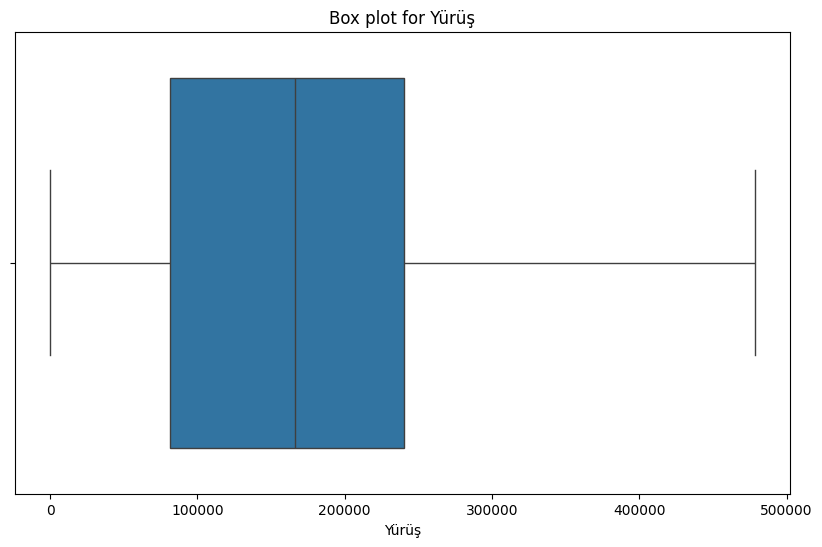

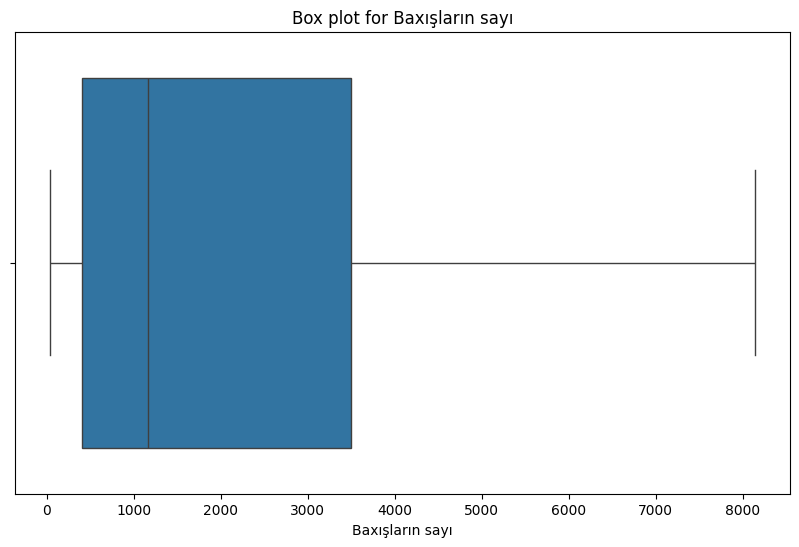

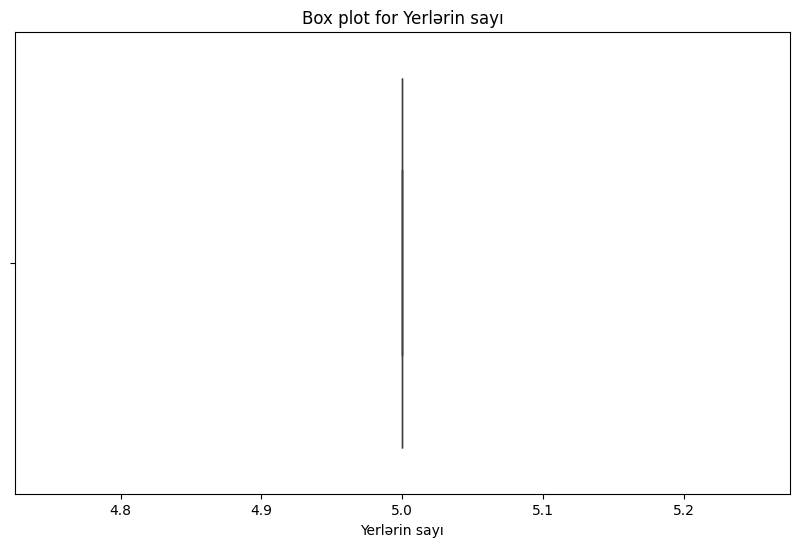

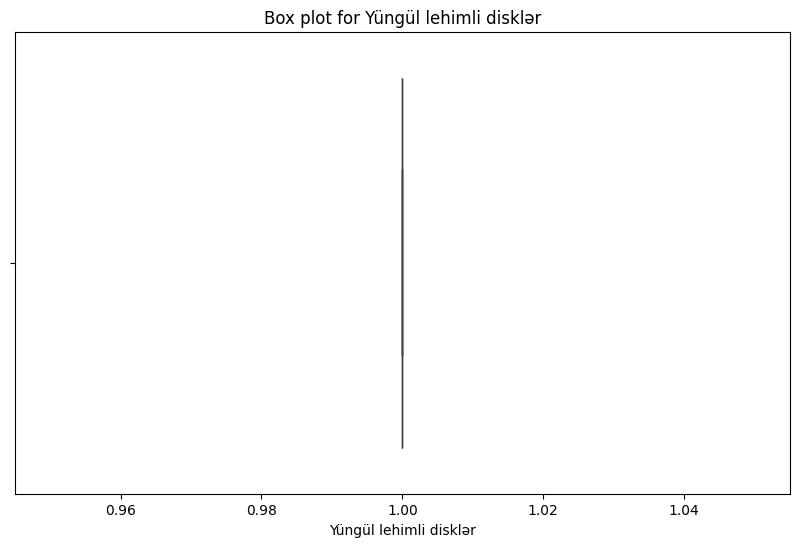

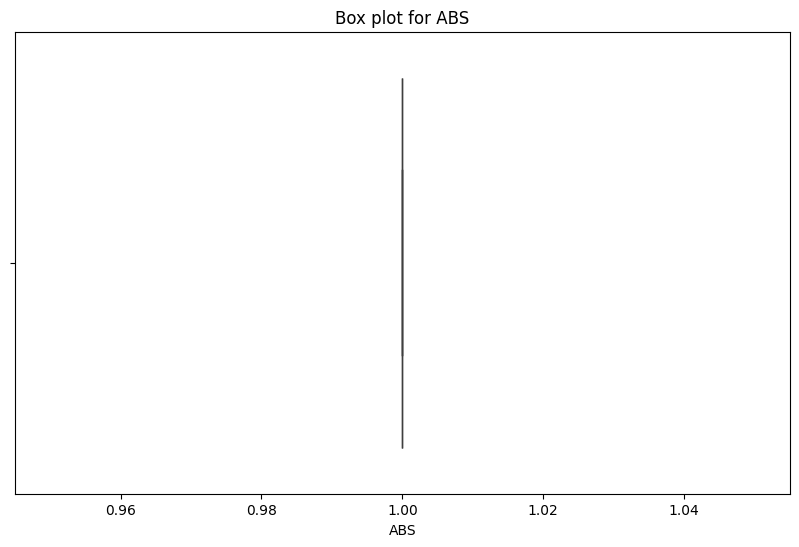

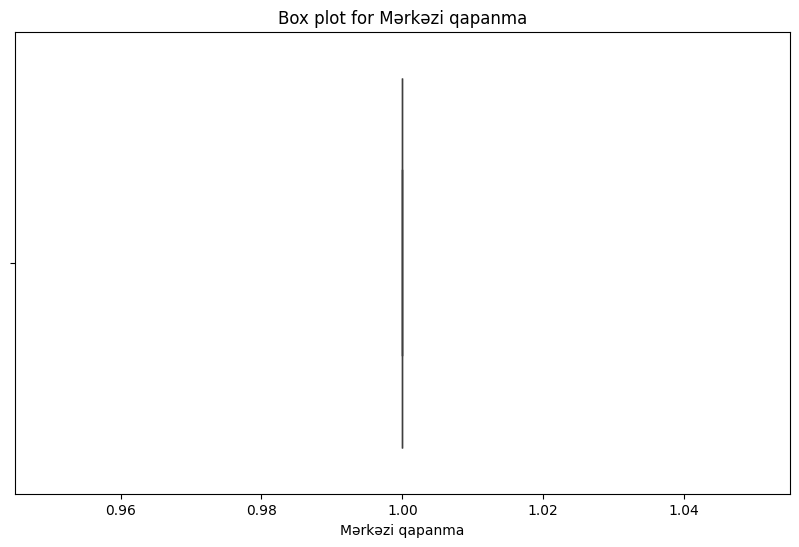

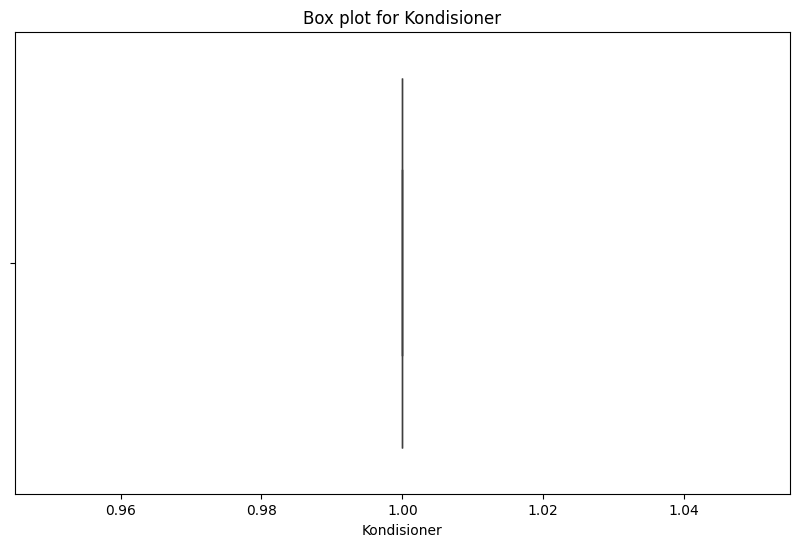

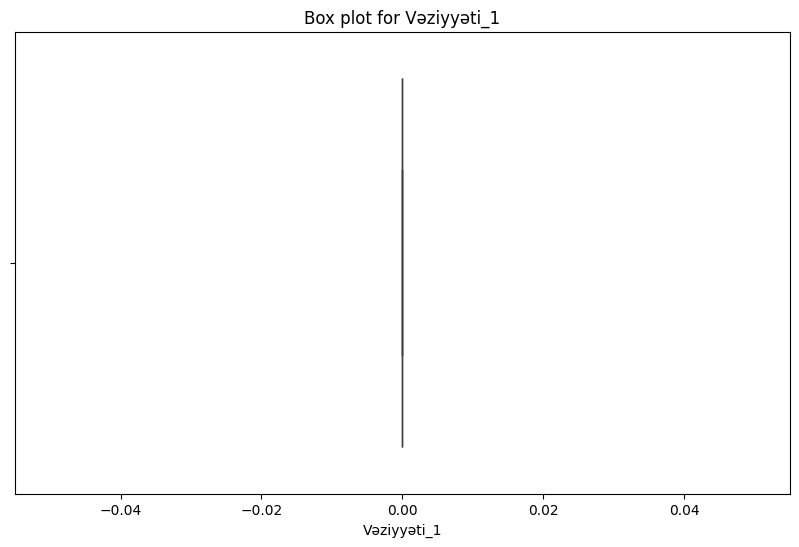

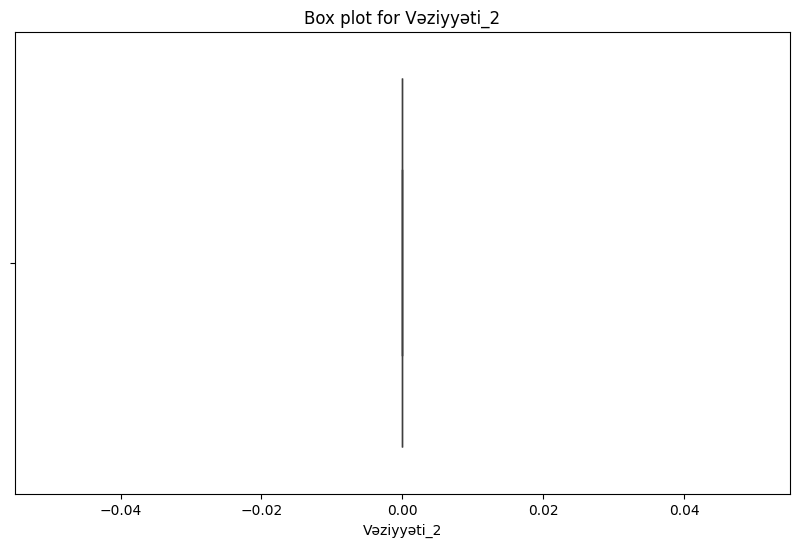

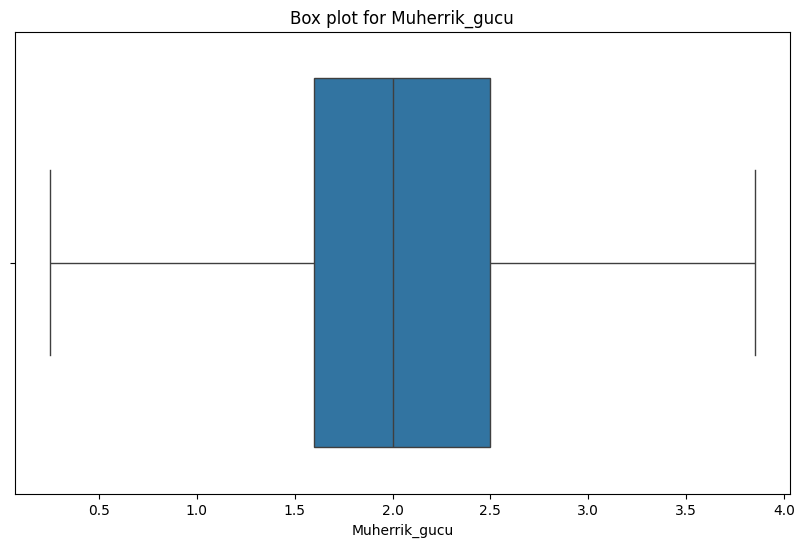

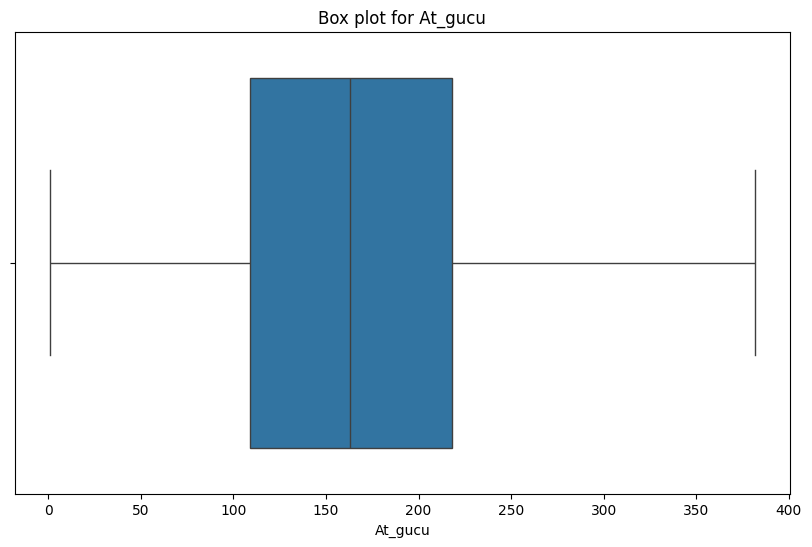

In [83]:
def plot_outliers(df):
    for col in num_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[col])
        plt.title(f'Box plot for {col}')
        plt.show()

plot_outliers(df)

## Scaling

In [84]:
numeric_data = df.select_dtypes(include=[np.number])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

In [85]:
# pca = PCA(n_components=2)
# pca_data = pca.fit_transform(scaled_data)

# explained_variance = pca.explained_variance_ratio_
# print(f"Explained variance ratio: {explained_variance}")

# pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
# df = pd.concat([df, pca_df], axis=1)

In [86]:
df.head()

,Avtosalon,Qiymet,Marka,Model,Buraxılış ili,Ban növü,Yürüş,Sürətlər qutusu,Ötürücü,Yeni,...,Dəri salon,Ksenon lampalar,Arxa görüntü kamerası,Yan pərdələr,Oturacaqların ventilyasiyası,Vəziyyəti_1,Vəziyyəti_2,Muherrik_gucu,At_gucu,Yanacag
0,0,13500.0,Opel,Vectra,2000,Hetçbek,370000.0,Mexaniki,Ön,Xeyr,...,1,1,0,1,0,0.0,0.0,1.6,101.0,Benzin
1,1,39950.0,Toyota,Corolla,2023,Sedan,0.0,Avtomat,Ön,Bəli,...,0,1,1,1,1,0.0,0.0,1.8,178.0,Hibrid
2,0,33200.0,Hyundai,Santa Fe,2013,Offroader / SUV,168636.0,Avtomat,Ön,Xeyr,...,1,1,1,1,1,0.0,0.0,2.0,184.0,Dizel
3,0,17000.0,Ford,Fusion,2015,Sedan,120873.0,Avtomat,Ön,Xeyr,...,0,1,1,1,0,0.0,0.0,1.5,181.0,Benzin
4,0,61200.0,Toyota,RAV4,2022,Offroader / SUV,0.0,Avtomat,Ön,Bəli,...,1,1,1,0,0,0.0,0.0,2.0,173.0,Benzin


## VIF

In [87]:
def drop_features_with_high_vif(data_frame = None, vif_threshold = 5):
    features = data_frame.select_dtypes(include = 'number').drop(columns = 'Qiymet').columns.tolist()
    X = data_frame[features].copy()
    imputer = SimpleImputer(strategy = 'median')
    X = pd.DataFrame(data = imputer.fit_transform(X = X), columns = features)
    
    vif_df = pd.DataFrame()
    vif_df['feature'] = X.columns
    vif_df['vif_value'] = [VIF(exog = X.values, exog_idx = i) for i in range(len(X.columns))]
    
    features_with_max_vif_value = []
    
    while vif_df.vif_value.max() > vif_threshold:
        feature_with_max_vif_value = vif_df.loc[vif_df.vif_value == vif_df.vif_value.max(), 'feature'].values[0]
        features_with_max_vif_value.append(feature_with_max_vif_value)
        X.drop(columns = feature_with_max_vif_value, inplace = True)
        
        vif_df = pd.DataFrame()
        vif_df['feature'] = X.columns
        vif_df['vif_value'] = [VIF(exog = X.values, exog_idx = i) for i in range(len(X.columns))]
    
    data_frame.drop(columns = features_with_max_vif_value, inplace = True)
    
    return data_frame

In [88]:
df = drop_features_with_high_vif(data_frame = df)
df.head()

,Avtosalon,Qiymet,Marka,Model,Buraxılış ili,Ban növü,Yürüş,Sürətlər qutusu,Ötürücü,Yeni,...,Dəri salon,Ksenon lampalar,Arxa görüntü kamerası,Yan pərdələr,Oturacaqların ventilyasiyası,Vəziyyəti_1,Vəziyyəti_2,Muherrik_gucu,At_gucu,Yanacag
0,0,13500.0,Opel,Vectra,2000,Hetçbek,370000.0,Mexaniki,Ön,Xeyr,...,1,1,0,1,0,0.0,0.0,1.6,101.0,Benzin
1,1,39950.0,Toyota,Corolla,2023,Sedan,0.0,Avtomat,Ön,Bəli,...,0,1,1,1,1,0.0,0.0,1.8,178.0,Hibrid
2,0,33200.0,Hyundai,Santa Fe,2013,Offroader / SUV,168636.0,Avtomat,Ön,Xeyr,...,1,1,1,1,1,0.0,0.0,2.0,184.0,Dizel
3,0,17000.0,Ford,Fusion,2015,Sedan,120873.0,Avtomat,Ön,Xeyr,...,0,1,1,1,0,0.0,0.0,1.5,181.0,Benzin
4,0,61200.0,Toyota,RAV4,2022,Offroader / SUV,0.0,Avtomat,Ön,Bəli,...,1,1,1,0,0,0.0,0.0,2.0,173.0,Benzin


## Encoding

In [89]:
df[['Yeni']] = df[['Yeni']].applymap({'Xeyr': 0, 'Bəli': 1}.get)

In [90]:
encoder = ce.LeaveOneOutEncoder(cols = ['Marka','Model','Ban növü'], sigma=0.1)
df[['Marka','Model','Ban növü']] = encoder.fit_transform(df[['Marka','Model','Ban növü']], df['Qiymet'])

In [91]:
encoder = OrdinalEncoder(categories=[['Ön', 'Arxa', 'Tam']])
df['Ötürücü'] = encoder.fit_transform(df[['Ötürücü']])

In [92]:
encoder = OrdinalEncoder(categories=[['Mexaniki', 'Avtomat', 'Variator', 'Robotlaşdırılmış']])
df['Sürətlər qutusu'] = encoder.fit_transform(df[['Sürətlər qutusu']])

In [93]:
encoder = OrdinalEncoder(categories=[['Benzin', 'Dizel', 'Plug-in Hibrid', 'Hibrid', 'Qaz', 'Elektro']])
df['Yanacag'] = encoder.fit_transform(df[['Yanacag']])

In [94]:
df = pd.get_dummies(df, columns = ['Hansı bazar üçün yığılıb'])

In [95]:
df.head()

,Avtosalon,Qiymet,Marka,Model,Buraxılış ili,Ban növü,Yürüş,Sürətlər qutusu,Ötürücü,Yeni,...,At_gucu,Yanacag,Hansı bazar üçün yığılıb_Amerika,Hansı bazar üçün yığılıb_Avropa,Hansı bazar üçün yığılıb_Digər,Hansı bazar üçün yığılıb_Dubay,Hansı bazar üçün yığılıb_Koreya,Hansı bazar üçün yığılıb_Rusiya,Hansı bazar üçün yığılıb_Rəsmi diler,Hansı bazar üçün yığılıb_Yaponiya
0,0,13500.0,10847.417843,5724.416371,2000,15380.489711,370000.0,0.0,0.0,0,...,101.0,0.0,False,True,False,False,False,False,False,False
1,1,39950.0,49317.802125,22693.929630,2023,27212.235831,0.0,1.0,0.0,1,...,178.0,3.0,False,False,False,False,False,False,True,False
2,0,33200.0,24097.732343,31778.155977,2013,57599.075642,168636.0,1.0,0.0,0,...,184.0,1.0,False,True,False,False,False,False,False,False
3,0,17000.0,30092.330854,19439.688713,2015,27800.683990,120873.0,1.0,0.0,0,...,181.0,0.0,False,True,False,False,False,False,False,False
4,0,61200.0,42619.923789,50033.268167,2022,51822.970359,0.0,1.0,0.0,1,...,173.0,0.0,False,True,False,False,False,False,False,False


## Feature Selection

In [96]:
X = df.drop(columns =['Qiymet'])
y = df['Qiymet']

lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

selected_features_indices = np.where(lasso.coef_ != 0)[0]

In [97]:
selected_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 13, 14, 16, 18, 19, 20, 21,
       22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], dtype=int64)

In [98]:
selected_features = X.columns[selected_features_indices].tolist()
len(selected_features)

30

## Train Test split

In [99]:
X = df[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6700, 30), (6700,), (3300, 30), (3300,))

# Model Building

## Linear Regression

In [100]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

Linear Regression Metrics:
MAE: 12465.841999226082
MSE: 527060771.9397991
RMSE: 22957.80416197941
R^2: 0.7646822850837941


## Random Forest

In [101]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor Metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

Random Forest Regressor Metrics:
MAE: 5194.301483272728
MSE: 279485303.3571456
RMSE: 16717.81395270164
R^2: 0.8752177235717742


## GBR

In [102]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Gradient Boosting Regressor Metrics:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

Gradient Boosting Regressor Metrics:
MAE: 6482.057326154955
MSE: 574574723.0277259
RMSE: 23970.28833843527
R^2: 0.7434686509225927


# Cross-Validasiya Tetbiqi

In [103]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
gbm_model = GradientBoostingRegressor(random_state=42)

rf_predictions = cross_val_predict(rf_model, X, y, cv=kf)
rf_mae = mean_absolute_error(y, rf_predictions)
rf_mse = mean_squared_error(y, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y, rf_predictions)

gbm_predictions = cross_val_predict(gbm_model, X, y, cv=kf)
gbm_mae = mean_absolute_error(y, gbm_predictions)
gbm_mse = mean_squared_error(y, gbm_predictions)
gbm_rmse = np.sqrt(gbm_mse)
gbm_r2 = r2_score(y, gbm_predictions)

def print_metrics(model_name, mae, mse, rmse, r2):
    print(f"{model_name} Metrics:")
    print(f"  MAE: {mae:,.2f}")
    print(f"  MSE: {mse:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R^2: {r2:.2f}")
    print() 

print_metrics("Random Forest", rf_mae, rf_mse, rf_rmse, rf_r2)
print_metrics("Gradient Boosting", gbm_mae, gbm_mse, gbm_rmse, gbm_r2)

Random Forest Metrics:
  MAE: 5,290.66
  MSE: 406,398,174.82
  RMSE: 20,159.32
  R^2: 0.84

Gradient Boosting Metrics:
  MAE: 6,336.32
  MSE: 488,068,494.79
  RMSE: 22,092.27
  R^2: 0.81

